In [1]:
import numpy as np
from multiprocessing import managers, shared_memory
import enum
from concurrent import futures
import xarray as xr
import gcsfs
from typing import Dict, List
import torch
from collections import namedtuple
from dataclasses import dataclass
from functools import partial
import cv2 as cv
import matplotlib.pyplot as plt

In [2]:
# Override is_retriable.  Google Cloud sometimes throws
# a HttpError code 400.  gcsfs considers this to not be retriable.
# But it is retriable!

def is_retriable(exception):
    """Returns True if this exception is retriable."""
    errs = list(range(500, 505)) + [
        # Jack's addition.  Google Cloud occasionally throws Bad Requests for no apparent reason.
        400,
        # Request Timeout
        408,
        # Too Many Requests
        429,
    ]
    errs += [str(e) for e in errs]
    if isinstance(exception, gcsfs.utils.HttpError):
        return exception.code in errs

    return isinstance(exception, gcsfs.utils.RETRIABLE_EXCEPTIONS)

gcsfs.utils.is_retriable = is_retriable

In [3]:
ZARR = 'solar-pv-nowcasting-data/satellite/EUMETSAT/SEVIRI_RSS/OSGB36/all_zarr_int16'
gcs = gcsfs.GCSFileSystem()
gcs.retries = 60
store = gcsfs.GCSMap(root=ZARR, gcs=gcs)

In [4]:
%%time
dataset = xr.open_zarr(store, consolidated=True)

CPU times: user 1.78 s, sys: 115 ms, total: 1.9 s
Wall time: 4.84 s


In [5]:
OPT_FLOW_DTYPE = np.float32


def convert_10bpp_to_uint8(array):
    "Convert 10 bit per pixel to uint8"
    # Divide by 4 to get from a range of [0, 1023] to [0, 255].
    array = array / 4.0
    array = array.round()
    assert array.min() >= 0
    assert array.max() <= 255
    return array.astype(np.uint8)


def _compute_optical_flow_worker_process(
    timestep: int, 
    sat_data_shape: tuple, 
    sat_data_shared_mem: shared_memory.SharedMemory, 
    opt_flow_shared_mem: shared_memory.SharedMemory) -> None:
    """To be run as a separate process. Gets sat data from shared memory.
    Computes optical flow for pair of images (at timesteps t and t+1).
    
    Args:
        timestep: Index into sat_data for the first image on which to compute
            optical flow.  The 2nd image used for optical flow is at timestep+1.
        sat_data_shape: Tuple of (num_timesteps, height, width)
        sat_data_shared_mem: SharedMemory object.  Note that the full array isn't copied into
            each process.  Instead, memory is shared between processes.
        opt_flow_shared_mem: SharedMemory into which this function inserts the computed optical flow field.
    """
    # Attach to existing memory block for satellite data.
    sat_data_shared_array = np.ndarray(sat_data_shape, dtype=np.uint8, buffer=sat_data_shared_mem.buf)
    
    # Attach to existing memory block for the optical flow fields.
    num_timesteps, height, width = sat_data_shape
    opt_flow_shape = (num_timesteps-1, height, width, 2)
    opt_flow_shared_array = np.ndarray(opt_flow_shape, dtype=OPT_FLOW_DTYPE, buffer=opt_flow_shared_mem.buf)
    
    prev_img = sat_data_shared_array[timestep]
    next_img = sat_data_shared_array[timestep+1]
    
    flow = cv.calcOpticalFlowFarneback(
        prev=prev_img, next=next_img, flow=None, pyr_scale=0.5, levels=2, winsize=40, iterations=3, 
        poly_n=5, poly_sigma=0.7, flags=cv.OPTFLOW_FARNEBACK_GAUSSIAN)
    
    # Copy flow to shared memory.
    opt_flow_shared_array[timestep] = flow[:]


def compute_optical_flow(sat_data: xr.DataArray) -> xr.DataArray:
    """Compute optical flow for each pair of consecutive images using multiple processes.

    Args:
        sat_data: Satellite data loaded from disk.
        
    Returns:
        optical flow fields as xr.DataArray, with the 'time' dimension set to the time
        of the second of the pair of input satellite images.
    """
    # OpenCV expects uint8 images
    sat_data_uint8 = convert_10bpp_to_uint8(sat_data)
    num_timesteps, height, width = sat_data_uint8.shape

    # Create a non-shared array for the resulting optical flow fields.
    num_flows = num_timesteps - 2
    opt_flow_shape = (num_flows, height, width, 2)
    opt_flow_array = np.empty(opt_flow_shape, dtype=OPT_FLOW_DTYPE)

    # To speed up processing, we use multiple processes to compute the optical flow fields.
    # Prior to Python 3.8, we'd have to pass the sat data array and the optical flow
    # arrays using pipes or on-disk files.  That's slow.  Python 3.8 allows us to share
    # memory between processes, which is much faster.
    with managers.SharedMemoryManager() as smm:
        # Create shared array for the uint8 satellite imagery.
        sat_data_shared_mem = smm.SharedMemory(size=sat_data_uint8.nbytes)
        sat_data_shared_array = np.ndarray(sat_data_uint8.shape, dtype=np.uint8, buffer=sat_data_shared_mem.buf)
        sat_data_shared_array[:] = sat_data_uint8[:]

        # Create a shared array for the resulting optical flow fields.
        opt_flow_shared_mem = smm.SharedMemory(size=opt_flow_array.nbytes)
        opt_flow_shared_array = np.ndarray(opt_flow_shape, dtype=OPT_FLOW_DTYPE, buffer=opt_flow_shared_mem.buf)

        # Fire up a bunch of processes to compute optical flow indexed on the first
        # image of the pair of images to compute optical flow for.  ProcessPoolExecutor
        # defaults to use the number of processors on the machine.
        
        opt_flow_func = partial(
            _compute_optical_flow_worker_process, 
            sat_data_shape=sat_data_uint8.shape,
            sat_data_shared_mem=sat_data_shared_mem,
            opt_flow_shared_mem=opt_flow_shared_mem)
        with futures.ProcessPoolExecutor() as executor:
            executor.map(opt_flow_func, range(num_flows))

        # Copy results into non-shared array.
        opt_flow_array[:] = opt_flow_shared_array[:]

    # Wrap opt_flow_array in an xr.DataArray with appropriate dimensions.
    coords = (
        ('time', sat_data['time'][1:-1]),
        ('y', sat_data['y']),
        ('x', sat_data['x']),
        ('optical_flow_displacement', ['x', 'y']))
    
    return xr.DataArray(opt_flow_array, coords=coords, name='optical flow')

In [26]:
def remap_image(image: np.ndarray, flow: np.ndarray) -> np.ndarray:
    """Takes an image and warps it forwards in time according to the flow field.
    
    Args:
        image: The grayscale image to warp.
        flow: A 3D array.  The first two dimensions must be the same size as the first two
            dimensions of the image.  The third dimension represented the x and y displacement.
            
    Returns:  Warped image.
    """
    # Adapted from https://github.com/opencv/opencv/issues/11068
    height, width = flow.shape[:2]
    remap = -flow.copy()
    remap[..., 0] += np.arange(width)  # map_x
    remap[..., 1] += np.arange(height)[:, np.newaxis]  # map_y
    return cv.remap(
        src=image, map1=remap, map2=None, 
        interpolation=cv.INTER_LINEAR, borderMode=cv.BORDER_REPLICATE)


def compute_optical_flow_predictions(sat_data: xr.DataArray, flows: xr.DataArray):
    """Compute predictions.

    For each source image (S), and optical flow field (F), we create a predicted image (P) like this:

    source image timestep: 012345
                           SSSSSS
                            FFFF
                             PPPP
                              PPP
                               PP
                                P

    For n source images, we have n-2 flows, and (n-2)*(n-1)/2 predictions.  In the illustration,
    we have 6 source images, 4 flows, and 10 predictions.

    Source image 0 and 1 make the first flow.  Source image 0 and the first flow go into
    making the first prediction (which is for source timestep 2.  That is, we take source image
    1 and predict source image 2.)
    
    Returns metadata, predictions
        metadata: a list of dicts. Each dict has keys 'date_forecast_about' (np.datetime64)
          and 'forecast_horizon' (np.timedelta64).  There is one metadata entry for each prediction.
        predictions: np.ndarray of shape (num_predictions, height, width)
    """

    num_source_timesteps, height, width = sat_data.shape
    num_predictions = int((num_source_timesteps-2) * (num_source_timesteps-1) / 2)
    predictions_shape = (num_predictions, height, width)
    predictions = np.empty(predictions_shape, dtype=np.float32)

    num_flows = num_source_timesteps - 2
    prediction_i = 0
    prediction_metadata = []

    for flow_i in range(num_flows):
        print(f'FLOW {flow_i:02d}: ', end='')
        for forecast_horizon in range(1, (num_flows - flow_i)+1):
            print(f'{prediction_i:03d}, ', end='')
            first_image = sat_data[flow_i+1]
            predicted_image = remap_image(first_image.values, flows[flow_i].values * forecast_horizon)
            predictions[prediction_i] = predicted_image[:]

            forecast_horizon_td = np.timedelta64(forecast_horizon * MINUTES_PER_TIMESTEP, 'm')
            prediction_metadata.append({
                'date_forecast_about': first_image['time'].values + forecast_horizon_td,
                'forecast_horizon': forecast_horizon_td})
            prediction_i += 1
        print()
        
    return {'metadata': prediction_metadata, 'images': predictions}

In [34]:
TIMESTEPS_PER_HOUR = 12  # One timestep every 5 minutes.
MINUTES_PER_TIMESTEP = 5
NUM_RETRIES = 5

DateRange = namedtuple('DateRange', ['start', 'end'])


class BatchType(enum.Enum):
    TRAINING = 0
    TESTING = 1
    

@dataclass
class SatelliteLoader:
    """Loads satellite data from disk into CPU memory.
    
    Optical flow & optical flow predictions are computed in parallel on the fly.
    
    We don't explicity set a date range for training so the code can 
    automatically make use of new training data when the dataset is updated
    with new satellite data.

    Init params:
        dataset: xarray dataset of int16 EUMETSAT satellite images.
        num_epochs:
        num_forecast_timesteps: Number of timesteps ahead to predict.  Each timestep is 5 minutes long.
        testing_date_range: Date range to exclude from training data.  
            If the testing_date_range contains more data
            than can fit into a single super batch then the chronologically late
            data will not be used in either training or testing.
        rng: Random number generator.
    """
    dataset: xr.Dataset  # The only variable that _has_ to be passed in.
    num_epochs: int = 20
    num_forecast_timesteps: int = 24

    # TODO: Accept multiple date ranges.
    testing_date_range: DateRange = DateRange(start=np.datetime64('2019-06-01'), end=np.datetime64('2019-06-14'))
        
    rng: np.random.Generator = np.random.default_rng()

    def __post_init__(self):
        # Select just the HRV channel.
        HRV_CHANNEL = 0
        data_array = self.dataset['stacked_eumetsat_data'][..., HRV_CHANNEL]

        # Our int16 array represents NaNs as '-1'.  Lazily replace -1s with NaNs.
        data_array = data_array.astype(np.float32).where(data_array != -1, np.NaN)
        self.data_array = data_array

        # valid_start_dates is a dict mapping TRAINING and TESTING to valid start dates.
        self.valid_start_times = self._compute_valid_start_times(data_array['time'])
        
    def _compute_valid_start_times(self, datetimes) -> Dict[BatchType, np.array]:
        """Find start times for testing and training.
        
        Returns dict {TESTING: array of dates; TRAINING: array of dates}"""

        # TODO: Use clear sky irradiance to compute good hours.
        # TODO: Only select start-times which align with the start of Zarr chunks?

        datetime_index = datetimes.to_index()
        hours = datetime_index.hour
        forecast_hours = self.num_forecast_timesteps / TIMESTEPS_PER_HOUR
        end_hour = 16 - forecast_hours
        mask = (hours > 9) & (hours < end_hour)
        masked_datetimes = datetimes[mask]

        testing_mask = (self.testing_date_range.start < masked_datetimes) &  (self.testing_date_range.end > masked_datetimes)
        return {
            BatchType.TRAINING: masked_datetimes[~testing_mask].values,
            BatchType.TESTING: masked_datetimes[testing_mask].values}

    def load_satellite_data(self, batch_type: BatchType=BatchType.TRAINING) -> xr.DataArray:
        """Randomly pick a chunk of data to load off disk.

        Args:
            batch_type: Select training or testing.
        """
        # TODO: Load several complete chunks at once to make best use of Zarr's parallel reading.
        # We'll need to modify compute_optical_flow so it doesn't attempt to compute
        # optical flow for two images which are not exactly consecutive.
        
        # TODO: Figure out how many Zarr chunks to load so that the
        # resulting data fits into a super batch.
        # Consider: For the last forecast_timesteps steps in a consecutive chunk,
        # we'll have decreasingly few ground-truth examples.

        start_times = self.valid_start_times[batch_type]
        
        for retry in range(NUM_RETRIES):
            start_time = self.rng.choice(start_times)
            end_time = start_time + np.timedelta64(self.num_forecast_timesteps * MINUTES_PER_TIMESTEP, 'm')
            sat_data = self.data_array.sel(time=slice(start_time, end_time))
            if len(sat_data) == self.num_forecast_timesteps + 1:
                print(f'Found good data after {retry} retries.')
                break
        else:
            raise ValueError(f'Failed to find valid data after {NUM_RETRIES} retries!')
            
        return sat_data.compute()

    def load_super_batch(self, batch_type: BatchType=BatchType.TRAINING) -> Dict[str, xr.DataArray]:
        """Returns pinned array."""
        satellite_data = self.load_satellite_data(batch_type)
        optical_flow = compute_optical_flow(satellite_data)
        # TODO:  Rolling average of flow fields.

        opt_flow_predictions = compute_optical_flow_predictions(satellite_data, optical_flow)
        
        super_batch = {
            'input_images': opt_flow_predictions['images'],
            'input_metadata': opt_flow_predictions['metadata'],
            'target_images': satellite_data}

        return super_batch

In [35]:
%%time
loader = SatelliteLoader(dataset)

CPU times: user 128 ms, sys: 0 ns, total: 128 ms
Wall time: 126 ms


In [36]:
len(loader.valid_start_times[BatchType.TESTING])

624

In [37]:
%%time
super_batch = loader.load_super_batch()

Found good data after 0 retries.
FLOW 00: 000, 001, 002, 003, 004, 005, 006, 007, 008, 009, 010, 011, 012, 013, 014, 015, 016, 017, 018, 019, 020, 021, 022, 
FLOW 01: 023, 024, 025, 026, 027, 028, 029, 030, 031, 032, 033, 034, 035, 036, 037, 038, 039, 040, 041, 042, 043, 044, 
FLOW 02: 045, 046, 047, 048, 049, 050, 051, 052, 053, 054, 055, 056, 057, 058, 059, 060, 061, 062, 063, 064, 065, 
FLOW 03: 066, 067, 068, 069, 070, 071, 072, 073, 074, 075, 076, 077, 078, 079, 080, 081, 082, 083, 084, 085, 
FLOW 04: 086, 087, 088, 089, 090, 091, 092, 093, 094, 095, 096, 097, 098, 099, 100, 101, 102, 103, 104, 
FLOW 05: 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 
FLOW 06: 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 
FLOW 07: 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 
FLOW 08: 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 
FLOW 09: 171, 172, 173

In [42]:
assert len(super_batch['input_metadata']) == len(super_batch['input_images'])

In [50]:
i = 200
super_batch['input_metadata'][i]

{'date_forecast_about': numpy.datetime64('2018-06-14T13:14:00.000000000'),
 'forecast_horizon': numpy.timedelta64(15,'m')}

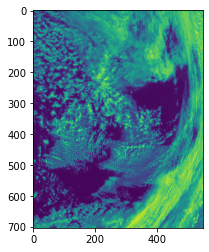

In [51]:
plt.imshow(super_batch['input_images'][i]);

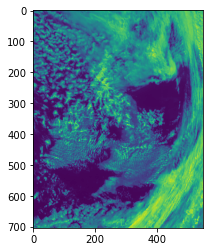

In [52]:
plt.imshow(super_batch['target_images'].sel(time=super_batch['input_metadata'][i]['date_forecast_about']));

In [53]:
super_batch['input_images'].nbytes / 1E6

425.914368

In [55]:
super_batch['target_images'].nbytes / 1E6

38.5792

In [58]:
input_datetimes = [d['date_forecast_about'] for d in super_batch['input_metadata']]

In [60]:
len(input_datetimes)

276

In [69]:
input_idx_to_target_idx = np.array([np.where(super_batch['target_images'].time.values == input_datetime)[0][0]
  for input_datetime in input_datetimes])

In [71]:
input_idx = 10
target_idx = input_idx_to_target_idx[input_idx]

In [72]:
super_batch['input_metadata'][input_idx]

{'date_forecast_about': numpy.datetime64('2018-06-14T12:59:00.000000000'),
 'forecast_horizon': numpy.timedelta64(55,'m')}

In [73]:
super_batch['target_images'][target_idx]

<xarray.DataArray 'stacked_eumetsat_data' (y: 704, x: 548)>
array([[312., 342., 325., ..., 643., 667., 693.],
       [394., 398., 394., ..., 588., 597., 629.],
       [423., 427., 423., ..., 544., 538., 560.],
       ...,
       [377., 412., 405., ..., 400., 448., 345.],
       [412., 372., 324., ..., 349., 460., 396.],
       [453., 399., 304., ..., 303., 366., 370.]], dtype=float32)
Coordinates:
    time      datetime64[ns] 2018-06-14T12:59:00
    variable  <U6 'HRV'
  * x         (x) int64 -238000 -236000 -234000 -232000 ... 852000 854000 856000
  * y         (y) int64 1222000 1220000 1218000 ... -180000 -182000 -184000

## TODO:

Take the code in the few cells above (getting input_idx_to_target_idx etc.) and use this in CPUSuperBatch to load a cpu super batch, with just a single call of `loader.load_super_batch()`.  To start with, don't worry about making this asynchronous - it's pretty quick, and will provide lots of training examples for a batch (because we still need to randomly select rectangles).

# PyTorch!

1. Asynchronously load a `cpu_super_batch` into CPU RAM in a separate process.
  - pre-allocate `cpu_super_batch`:
    - `pinned_tensor = torch.empty(shape, pin_memory=True)`
    - `pinned_numpy = pinned_tensor.numpy()`
    - `pinned_numpy` and `pinned_tensor` share memory
  - Results in 4 separate numpy arrays:
    1. Input images (optical flow predictions - full geographical extent), length _n_.
    2. Input metadata (forecast horizon of the optical flow images), length _n_.
    3. Target images (ground-truth satellite images - full geographical extent)
    4. Map from input index to target index (because many input images map to each target image).  This will be a 1D interger array, length _n_, where each value gives the corresponding target image index.
2. Copy this entire `cpu_super_batch` into a pre-allocated `gpu_super_batch`.
  - Synchronous copy.  Should take less than a second.  (We could consider having 2 gpu_super_batches, and async load one while the GPU is training on the other.  But let's keep things simple for now!)
3. Create `mini_batch` on the fly in a custom `IterableDataset`:
```python

```


In [10]:
from typing import Dict
import numpy as np
import torch
from dataclasses import dataclass

In [26]:
def create_empty_pinned_numpy_array(shape, dtype=torch.float32):
    pinned_tensor = torch.empty(*shape, dtype=dtype, pin_memory=True)
    return pinned_tensor.numpy()


@dataclass
class SuperBatch:
    """
    Attributes:
      image_height: int
      image_width: int
      n_input_images: len(input_images)
    
      input_images: Optical flow predictions, full geographical extent,
          shape (n_input_images, image_width, image_height)
      input_metadata: Forecast horizon of the optical flow images, length n_input_images
      target_images: Ground-truth satellite images, full geographical extent,
          shape: (length << n_input_images, image_width, image_height)
      input_idx_to_target_idx: Map from input index to target index (because
          many input images map to each target image).  1D interger array,
          length n_input_images, where each value gives the index of the
          corresponding target image.
          
    """
    n_input_images: int = 64
    image_width: int = 512
    image_height: int = 512
    
    def __post_init__(self, pre_allocate=True):
        if pre_allocate:
            self.pre_allocate()

    @property
    def image_shape(self):
        return (self.n_input_images, self.image_width, self.image_height)


class CPUSuperBatch(SuperBatch):
    
    def pre_allocate(self):
        self.input_images = create_empty_pinned_numpy_array(shape=self.image_shape)
        
    def load(self):
        """Asynchronously loads new CPU super batch from disk using a separate process.
        
        Non-blocking."""
        # TODO 
        pass

    def join(self):
        """Blocks until CPU super batch has finished loading."""
        # TODO 
        pass

In [ ]:
def sample_squares(mini_batch_full_geo_extent: Dict[str, torch.cuda.FloatTensor]) -> Dict[str, torch.cuda.FloatTensor]:
    """For each example, samples a random square from input_images and target_images."""
    pass

In [6]:
@dataclass
class GPUSuperBatch(SuperBatch):
    batch_size: int = 128

    def sample_mini_batch(self, batch_size) -> Dict[str, torch.cuda.FloatTensor]:
        """Returns a mini_batch, samples from gpu_super_batch.

        Each mini_batch is a dict[str, torch.cuda.FloatTensor].
        Keys are:
            input_images
            input_metadata
            target_images
        """
        idx_into_input = torch.randint(high=self._n, size=(self.batch_size, ))
        mini_batch_full_geo_extent = {}
        for key in [INPUT_IMAGES, INPUT_METADATA]:
            mini_batch_full_geo_extent[key] = getattr(self, key)[idx_into_input]
        idx_into_target = self.input_idx_to_target_idx[idx_into_input]
        mini_batch_full_geo_extent[TARGET_IMAGES] = self.target_images[idx_into_target]
        return sample_squares(mini_batch)
        
    def copy_(self, cpu_super_batch: CPUSuperBatch):
        """In-place copy from cpu_super_batch."""
        # TODO
        pass

In [6]:
@dataclass
class PVDataset(torch.utils.data.IterableDataset):
    """
    Attributes:
      n_super_batches:
      n_mini_batches_per_super_batch:
      _cpu_super_batch: CPUSuperBatch
      _gpu_super_batch: GPUSuperBatch
    """
    n_super_batches: int = 4
    n_mini_batches_per_super_batch: int = 128
    
    def __post_init__(self):
        self._cpu_super_batch = CPUSuperBatch()
        self._cpu_super_batch.load()
        self._gpu_super_batch = GPUSuperBatch()
    
    def __iter__(self):
        """Yields a mini_batches.

        Each mini_batch is a dict[str, torch.cuda.FloatTensor].
        Keys are:
            input_images
            input_metadata
            target_images
        """
        for _ in range(self.n_super_batches):
            self._cpu_super_batch.join()
            self._gpu_super_batch.copy_(self._cpu_super_batch)
            self._cpu_super_batch.load()
            for _ in range(self.n_mini_batches_per_super_batch):
                yield self._gpu_super_batch.sample_mini_batch()